# 3 Prepare Geographic Vector Data to Display

## 3.1 Software Requirements

In [409]:
import pandas as pd # Data handling
import geopandas as geopd # Handling shapefile
import matplotlib.pyplot as plt # Generating plots

In addition to these modules, you will likely need to install `descartes` module by `pip install descartes` to use geometric objects with matplotlib.

## 3.2 How to Handle Shapefiles

To handle shapefiles in python, you can use a library called `geopandas`. `read_file()` function of this library reads a shapefile as a `GeoDataFrame` object which is a `pandas.DataFrame` with a geometry column containing vector information.

Operations such as deleting rows and merging with other data frames are the same as for `pandas.DataFrame`. Thus you can manipulate shapefiles just as easily as with normal data frames in pandas.

In [410]:
filename = "./maps/cb_2018_us_state_500k.shp"
sf_us = geopd.read_file(filename)

In [411]:
type(sf_us)

geopandas.geodataframe.GeoDataFrame

We can check what kind of CRS this object is using by `.crs` attribute.

In [412]:
sf_us.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

We can see that this object looks exactly like a `pandas.DataFrame` by printing. 

In [413]:
sf_us.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


`geometry` column itself is an object called `GeoSeries`. A `GeoDataFrame` can be thought of as a `DataFrame` that holds a `GeoSeries` inside.

## 3.3 How to Draw a US Map

We can easily draw state boundaries recorded as multi polygons in the `geometry` column using [`.plot()`](https://geopandas.org/reference.html#geopandas.GeoDataFrame.plot)

<AxesSubplot:>

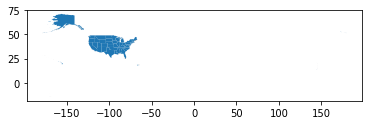

In [414]:
sf_us.plot()

In [415]:
dropstates = ["Alaska",
              "Hawaii",
              "Puerto Rico",
              "Guam",
              "United States Virgin Islands",
              "Commonwealth of the Northern Mariana Islands",
              "American Samoa"]

<AxesSubplot:>

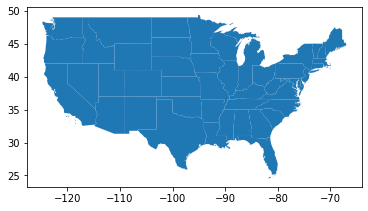

In [416]:
sf_us.query('NAME not in @dropstates').plot()

First, since Alaska is on the date line and divided into two pieces we change the range of longitude from -180-180 to 0-360. To do this, we need to edit the CRS used in this shapefile. (Since there is no tool in python similar to the function `st_shift_longitude()` used in the R example, we need to create a custom CRS.)

To refer to a CRS, there are two popular formats: the `EPSG` format and the `proj.4` format. For example, the data we are using in this tutorial is based on NAD83, which is expressed in each format as follows.

 - EPSG format : "EPSG:4269"
 - proj.4 format : "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"

The advantage of the proj.4 notation is that the user can add options to this string. For example, `+lat_0=` sets the latitude of origin, and `+lon_wrap=` sets the longitude to use for wrapping (Determine the left and right edge of the Earth).

The argument to `+lon_wrap=` is a center longitude. Thus, if we assign `+lon_wrap=180`, the entire coordinates will be shifted to 0-360.

In [417]:
nad83 = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"
wrap = " +lon_wrap=180"
sf_us_360 = sf_us.to_crs("".join([nad83,wrap]))

Then we shift and scale Alaska and Hawaii. There are many [geometric manipulations available in geopandas](https://geopandas.org/geometric_manipulations.html), including affine transformation by a matrix A, and shift, scale, or rotate by a certain latitude and longitude value.

Note that these operations are available for `GeoSeries`, and that the resulting output is only the `geometry` columns of the original `GeoDataFrame`. Therefore, after these operations, you need to overwrite the existing `geometry` column with the new `GeoSeries`. This can be achieved by using `.set_geometry()` in `GeoDataFrame`.

`.scale()` method returns scaled geometries. It allows us to specify not only the scaling factor in the x-y direction, but also the origin. We specify `center = 'centroid'` here because we want to scale Alaska and Hawaii around their original place. The amount of shift in the direction of latitude and longitude is the same as the value determined by trial and error in our R example.

In [418]:
Alaska = sf_us_360.query('NAME == "Alaska"')
Alaska_geo = Alaska.scale(xfact=0.3, yfact=0.3, origin='centroid'
                         ).translate(xoff=36, yoff=-38)
Alaska = Alaska.set_geometry(Alaska_geo)

In [419]:
Hawaii = sf_us_360.query('NAME == "Hawaii"')
Hawaii_geo = Hawaii.scale(xfact=0.3, yfact=0.3, origin='centroid'
                                    ).translate(xoff=53, yoff=5)
Hawaii = Hawaii.set_geometry(Hawaii_geo)

<AxesSubplot:>

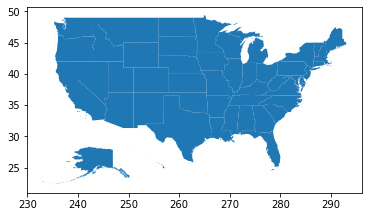

In [420]:
sf_us_shifted = geopd.GeoDataFrame(
    pd.concat(
        [sf_us_360.query('NAME not in @dropstates'),
         Alaska,
         Hawaii])
)
sf_us_shifted.plot()

# 4 Prepare Count Data to Display

## 4.1 Software Requirements

## 4.2 Merge COVID-19 Count with Geographic Data

# 5 Generate Choropleth Maps

## 5.1 Software Requirements

## 5.2 Show Choropleth Maps for each Quarter in 2020

# 6 Extended Example: Interactive Choropleth Maps

## 6.1 Software Requirements

## 6.2 Generate Interactive/Animated Choropleth Map